# Importing Libraries

In [1]:
# Importing Libraries
import os, pickle, glob, sys
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, when, udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DoubleType
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt

In [2]:
# Initializing SparkSession
sc = SparkSession.builder \
    .config("spark.driver.memory", "10g") \
	.config("spark.executor.memory", "10g") \
    .config('spark.executor.instances', 5) \
	.getOrCreate()
print(sc)

In [ ]:
# First time data zip unpacking
!unzip ./traffic_congestion.zip

Archive:  ./traffic_congestion.zip
replace us_congestion_2016_2022/us_congestion_2016_2022.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
csv_file = "./us_congestion_2016_2022/us_congestion_2016_2022.csv"

In [4]:
df = sc.read.csv(csv_file, header=True, inferSchema=True)

# Exploring Data

In [5]:
# Inspecting First Row
first_row = df.take(1)[0]
print(first_row)

Row(ID='C-1', Severity=0, Start_Lat=42.410881, Start_Lng=-71.147995, StartTime=datetime.datetime(2020, 11, 10, 14, 54), EndTime=datetime.datetime(2020, 11, 10, 16, 29, 27), Distance(mi)=3.990000009536743, DelayFromTypicalTraffic(mins)=0.0, DelayFromFreeFlowSpeed(mins)=4.0, Congestion_Speed='Moderate', Description='Delays of four minutes and delays increasing on Massachusetts Ave Westbound between MA-2A Massachusetts Ave and US-3 Mass Ave. Average speed 15 mph.', Street='Wyman Ter', City='Arlington', County='Middlesex', State='MA', Country='US', ZipCode='02474-6726', LocalTimeZone='US/Eastern', WeatherStation_AirportCode='KBED', WeatherTimeStamp=datetime.datetime(2020, 11, 10, 14, 51), Temperature(F)=64.0, WindChill(F)=64.0, Humidity(%)=63.0, Pressure(in)=29.93, Visibility(mi)=10.0, WindDir='SSW', WindSpeed(mph)=7.0, Precipitation(in)=0.0, Weather_Event=None, Weather_Conditions='Fair')


In [6]:
# Check the schema
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- StartTime: timestamp (nullable = true)
 |-- EndTime: timestamp (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- DelayFromTypicalTraffic(mins): double (nullable = true)
 |-- DelayFromFreeFlowSpeed(mins): double (nullable = true)
 |-- Congestion_Speed: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- ZipCode: string (nullable = true)
 |-- LocalTimeZone: string (nullable = true)
 |-- WeatherStation_AirportCode: string (nullable = true)
 |-- WeatherTimeStamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- WindChill(F): double (nullable = true)
 |-- Humidity(%): double 

In [7]:
def shape(df):
    num_rows = df.count()
    num_cols = len(df.columns)
    return num_rows, num_cols

df_rows, df_cols = shape(df)
print("DataFrame has {} rows and {} columns.".format(df_rows, df_cols))

DataFrame has 33304199 rows and 30 columns.


# Data Cleaning and Filtering

In [8]:
# Handle missing values
df = df.dropna()

# Remove duplicates
df = df.dropDuplicates()

In [9]:
# Filtering Fields
# Filter out specific fields we want to keep
fields_to_keep = ['ID', 'Severity', 'DelayFromFreeFlowSpeed(mins)', 'StartTime', 'Congestion_Speed', 'State', 'Pressure(in)', 'Visibility(mi)', 'WindSpeed(mph)', 'Precipitation(in)', 'Weather_Event']

# Filter out data that might be useless, like Delays that are less than 5 minutes. Reduces data to around 5 million data
filtered_df = df.select(*fields_to_keep).where(col("State").isNotNull()).where(col("DelayFromFreeFlowSpeed(mins)") > 5.0)
filtered_df.show()

+--------+--------+----------------------------+-------------------+----------------+-----+------------+--------------+--------------+-----------------+-------------+
|      ID|Severity|DelayFromFreeFlowSpeed(mins)|          StartTime|Congestion_Speed|State|Pressure(in)|Visibility(mi)|WindSpeed(mph)|Precipitation(in)|Weather_Event|
+--------+--------+----------------------------+-------------------+----------------+-----+------------+--------------+--------------+-----------------+-------------+
| C-88197|       2|           5.119999885559082|2018-11-28 21:18:00|        Moderate|   NY|       29.78|          10.0|          15.0|              0.0|         Snow|
| C-89281|       1|           6.269999980926514|2018-11-28 12:01:00|        Moderate|   MI|       29.92|           9.0|          18.4|              0.0|         Snow|
|C-106956|       2|            18.1200008392334|2018-11-28 23:42:00|            Slow|   MN|        29.9|           4.0|           8.1|              0.0|         Snow

In [10]:
# Grouping by State
state_count_df = filtered_df.groupBy("State").count()
state_count_df.show()

+-----+-----+
|State|count|
+-----+-----+
|   AZ| 1224|
|   SC|  679|
|   LA|  361|
|   MN| 7052|
|   NJ|11079|
|   DC|  441|
|   OR| 6069|
|   VA| 3471|
|   RI| 2265|
|   WY| 1866|
|   KY| 2588|
|   NH| 1699|
|   MI|12754|
|   NV| 1255|
|   WI| 2617|
|   ID| 1594|
|   CA| 7106|
|   NE| 2055|
|   CT| 6573|
|   MT| 2858|
+-----+-----+
only showing top 20 rows



In [11]:
# Cleaning 'Congestion_Speed' Column
df = df.withColumn("Congestion_Speed", when(col("Congestion_Speed") == "Slow", 0).when(col("Congestion_Speed") == "Moderate", 1).when(col("Congestion_Speed") == "Fast", 3))
df.show()

+--------+--------+---------+------------------+-------------------+-------------------+------------------+-----------------------------+----------------------------+----------------+--------------------+-----------------+----------------+----------+-----+-------+----------+-------------+--------------------------+-------------------+--------------+------------+-----------+------------+--------------+-------+--------------+-----------------+-------------+------------------+
|      ID|Severity|Start_Lat|         Start_Lng|          StartTime|            EndTime|      Distance(mi)|DelayFromTypicalTraffic(mins)|DelayFromFreeFlowSpeed(mins)|Congestion_Speed|         Description|           Street|            City|    County|State|Country|   ZipCode|LocalTimeZone|WeatherStation_AirportCode|   WeatherTimeStamp|Temperature(F)|WindChill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|WindDir|WindSpeed(mph)|Precipitation(in)|Weather_Event|Weather_Conditions|
+--------+--------+---------+-------------

In [12]:
# Grouping by 'Weather_Event' and Counting
weather_counts = filtered_df.groupBy("Weather_Event").count()
weather_counts.show()
#Thunderstorm, Rain, Fog, Snow, Tornado, Hail

+--------------------+------+
|       Weather_Event| count|
+--------------------+------+
|        Thunderstorm|   133|
|   Fog ;Thunderstorm|    75|
|  Rain ;Thunderstorm|   535|
|  Snow ;Thunderstorm|   195|
|                 Fog|  2807|
|Rain ;Snow ;Thund...|    11|
|Fog ;Snow ;Thunde...|   271|
|          Rain ;Snow|  1034|
|                Snow|148239|
|                Rain| 46503|
|          Snow ;Hail|     3|
|           Fog ;Rain|   813|
|Fog ;Rain ;Thunde...|     5|
|           Fog ;Snow| 49844|
|     Fog ;Rain ;Snow|    17|
|          Rain ;Hail|     2|
|Rain ;Hail ;Thund...|     1|
+--------------------+------+



In [13]:
# 1. Extract columns for the Accident table
accident_df = df.select(
    "ID", "Severity", "Start_Lat", "Start_Lng",
    "StartTime", "EndTime", "Distance(mi)",
    "DelayFromTypicalTraffic(mins)",
    "DelayFromFreeFlowSpeed(mins)", "Description"
)

# 2. Extract columns for the Location table
location_df = df.select(
    "ID", "Street", "City", "County", "State",
    "Country", "ZipCode", "LocalTimeZone"
)

# 3. Extract columns for the Weather table
weather_df = df.select(
    "ID", "WeatherStation_AirportCode", "WeatherTimeStamp",
    "Temperature(F)", "WindChill(F)", "Humidity(%)",
    "Pressure(in)", "Visibility(mi)", "WindDir",
    "WindSpeed(mph)", "Precipitation(in)",
    "Weather_Event", "Weather_Conditions"
)

testing_df = df.select(
    'ID', 'Severity', 'DelayFromFreeFlowSpeed(mins)', 'StartTime', 
    'Congestion_Speed', 'State', 'Pressure(in)', 'Visibility(mi)', 
    'WindSpeed(mph)', 'Precipitation(in)', 'Weather_Event'
)

# Write the normalized DataFrames to separate Parquet files
accident_df.write.mode("overwrite").parquet(f"{os.getcwd()}/parquet_data/accident_df.parquet")
location_df.write.mode("overwrite").parquet(f"{os.getcwd()}/parquet_data/location_table.parquet")
weather_df.write.mode("overwrite").parquet(f"{os.getcwd()}/parquet_data/weather_table.parquet")
testing_df.write.mode("overwrite").parquet(f"{os.getcwd()}/parquet_data/testing_df.parquet")

# Data Visualization

Matplotlib created a temporary cache directory at /scratch/jgao5/job_30349308/matplotlib-c94h_ni7 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


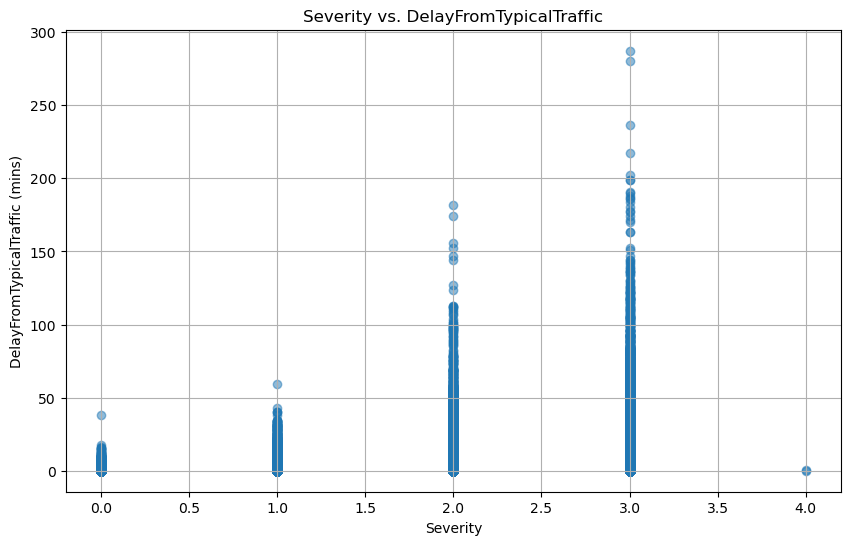

In [14]:
import matplotlib.pyplot as plt

# Read the Parquet file containing the Accident Table
accident_df = sc.read.parquet(f"{os.getcwd()}/parquet_data/accident_df.parquet")

# Select only Severity and DelayFromTypicalTraffic columns
severity_delay_df = accident_df.select("Severity", "DelayFromTypicalTraffic(mins)")

# Convert DataFrame to Pandas DataFrame
severity_delay_pd = severity_delay_df.toPandas()

# Plot Severity vs. DelayFromTypicalTraffic
plt.figure(figsize=(10, 6))
plt.scatter(severity_delay_pd['Severity'], severity_delay_pd['DelayFromTypicalTraffic(mins)'], alpha=0.5)
plt.title('Severity vs. DelayFromTypicalTraffic')
plt.xlabel('Severity')
plt.ylabel('DelayFromTypicalTraffic (mins)')
plt.grid(True)
plt.show()

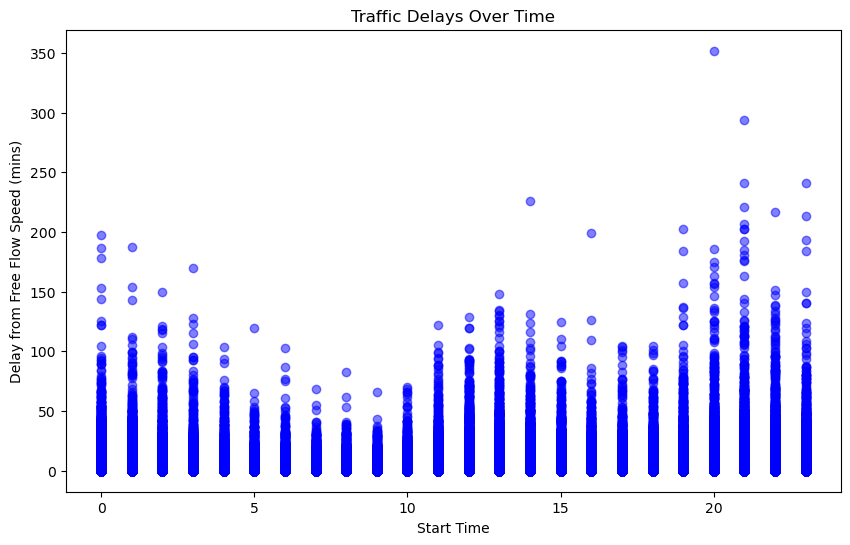

In [20]:
testing_df = sc.read.parquet(f"{os.getcwd()}/parquet_data/testing_df.parquet")
starttime_df = testing_df.select("DelayFromFreeFlowSpeed(mins)", "StartTime")
starttime_df = starttime_df.toPandas()

starttime_df['StartTime'] = pd.to_datetime(starttime_df['StartTime']).dt.hour


plt.figure(figsize=(10, 6))
plt.scatter(starttime_df['StartTime'], starttime_df['DelayFromFreeFlowSpeed(mins)'], color='b', alpha=0.5)
plt.title('Traffic Delays Over Time')
plt.xlabel('Military Time')
plt.ylabel('Delay from Free Flow Speed (mins)')
plt.show()

In [18]:
print(starttime_df)

        DelayFromFreeFlowSpeed(mins)           StartTime StartTimeOnly
0                               0.47 2018-11-28 12:24:00      12:24:00
1                               4.88 2018-11-28 12:31:00      12:31:00
2                               4.70 2018-11-28 12:06:00      12:06:00
3                               1.65 2018-11-28 21:27:00      21:27:00
4                               3.48 2018-11-28 10:16:00      10:16:00
...                              ...                 ...           ...
911431                          2.52 2016-12-12 05:54:00      05:54:00
911432                          2.05 2016-12-13 14:10:00      14:10:00
911433                          6.87 2018-02-14 14:40:00      14:40:00
911434                          0.00 2019-03-08 23:04:00      23:04:00
911435                          3.30 2018-02-15 12:31:00      12:31:00

[911436 rows x 3 columns]
